#### Convolution function: 
It accepts an image input, a filter kernel, stride, padding and the nonlinear function. The function must convolve the input image (after padding if specified) with the kernel (at the specified stride size) and generate an output activation after applying the specified non-linearity. Verify with the standard options for the non-linear activation functions - sigmoid, tanh, ReLU, Parametric ReLU (PReLU). Display the input image (e.g. small image of the IITH logo), the filter kernel and the output activation map. Ensure that your function can accept multi-channel input and a corresponding kernel volume. (6)

In [1]:
# import required libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image as Image2
from helper import *

In [2]:
'''
Get random kernel of no of channels -> ch and size -> sz
'''
def get_random_kernel(ch, sz):
    arr = np.random.randint(20, size=(ch, sz, sz))
    arr -= 10
    return arr    

'''
Get n_kernel random kernels of no of channels -> ch and size -> sz
'''
def gen_kernel(n_kernel, n_ch, sz):
    tmp = np.zeros((n_kernel, n_ch, sz, sz))
    
    for i in range(n_kernel):
        tmp[i] = get_random_kernel(n_ch, sz)
    
    return tmp

In [3]:
'''
image functions
'''
def read(image): 
    image = cv2.imread(image) 
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY) 
    return image

def show(image):
    image = rescale(image)
    plt.imshow(image)
    plt.show()
    
def write(img, path):
    cv2.imwrite(path, img)

def read_3d(path):
    img = Image.open(path)
    arr = np.array(img)
    return arr

def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)    
    
def save_3d(arr, path):
    arr = 255.0 * rescale(arr)
    img = Image.fromarray(arr.astype(int), 'RGB')
    img.save(path)
    
'''
Non linear functions
'''
def sigmoid(x):
    x = 1.0 / (1.0 + np.nan_to_num(np.exp(-1.0*x)))
    return x

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def prelu(x, num_channel=3):
    alpha = np.random.rand(num_channel, 1, 1)
    res = np.maximum(0, x) + alpha * np.minimum(0, x)
    return res

'''
pooling functions
'''
def max_pooling(x):
    return np.max(x, axis=(0,1))

def average_pooling(x):
    return np.mean(x, axis=(0,1))

'''
maths helper functions
'''
def softmax(x):
    """Compute softmax values for each row of x."""
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0)

### RESHAPE
def re_shape(kernel):
    ch, h, w = kernel.shape
    re = np.zeros((h, w, ch))
    
    for i in range(ch):
        for j in range(h):
            for k in range(w):
                re[j,k,i] = kernel[i,j,k]
    
    return re

In [4]:
'''
 convolution function
input parameters: 
    img -> image input (height x width x num_channel)
    kernel -> filter kernel (num_channel x f_ht x f_width)
    stride  -> optional parameter, default value = 1
    padding -> optional parameter, default value = 0
    activation -> activation function, default=identity function

output : (out_h, out_w)
Note : In helper.py, you can find relu, tanh, prelu and sigmoid.
'''
def convolution_d(img, kernel, stride=1, padding=0, activation=lambda x: x):
    in_height, in_width, num_channel = img.shape
    num_channel, filter_height, filter_width = kernel.shape
    
    # output image's dimensions
    out_height = int(((in_height - filter_height + 2*padding)/stride) + 1)
    out_width  = int(((in_width  - filter_width  + 2*padding)/stride) + 1)
    
    # Pad input if necessary
    if padding > 0:
        img = np.pad(img, ((padding,padding), (padding,padding), (0,0)), mode='constant')
    
    # initialise output with 0
    output = np.zeros((out_height, out_width))
    kernel = re_shape(kernel)

    for h in range(out_height):
        for w in range(out_width):
            h_start = h * stride
            h_end = h_start + filter_height
            w_start = w * stride
            w_end = w_start + filter_width
            chunk = img[h_start:h_end, w_start:w_end, :]
            output[h, w] = np.sum(chunk * kernel)  
    
    # Apply activation function
    output = activation(output)
    
    return output

#### Reading input for sample image 
read_3d returns a 3d numpy array with dimensions 3xhxw. kernel is also a 3x3x3 numpy array

In [5]:
img = read_3d('input.jpeg')
kernel = np.array(
[[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
 [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
 [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]])

print(f"input image shape : {img.shape}")
print(f"kernel shape : {kernel.shape}")

input image shape : (359, 638, 3)
kernel shape : (3, 3, 3)


In [6]:
out_img = convolution_d(img, kernel, stride=2, padding=1, activation=relu)
print(f"output shape : {out_img.shape}")

output shape : (180, 319)


Original image


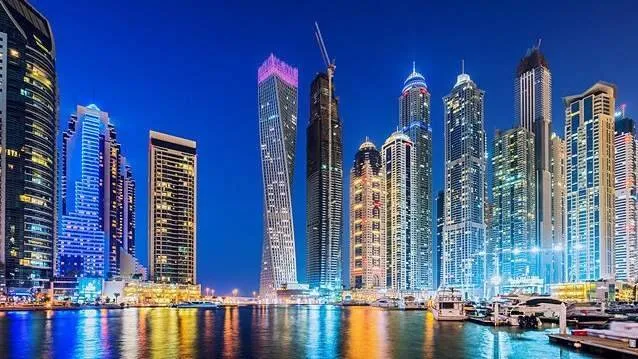

Output image


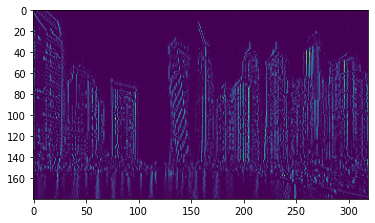

In [7]:
print("Original image")
display(Image2(filename='input.jpeg'))
print("Output image")
show(out_img)

### Pooling function: 
It accepts as input the activation map output from the convolution function,
a pooling function, and stride. The function must output the appropriately pooled activation map.
Display the input activation map and the pooled output. 

In [8]:
'''
image dimension : (height, width)
output dimension : (out_ht, out_width)
'''
def pooling(map_input, pooling_func, stride=1):
    h, w = map_input.shape

    # Calculate output dimensions
    oh = int(h/stride)
    ow = int(w/stride)
    output = np.zeros((oh, ow))
    
    # pooling operation
    for i in range(0, h - stride + 1, stride):
        for j in range(0, w - stride + 1, stride):
            # print(i,j,d)
            tmp = map_input[i:i+stride, j:j+stride]
            # print(tmp.shape)
            # print(f"tmp shape : {tmp.shape}")
            tmp_out = pooling_func(tmp)
            # print(tmp)
            # print(tmp_out)
            output[int(i/stride), int(j/stride)] = tmp_out

    return output

Input shape :
(359, 638)


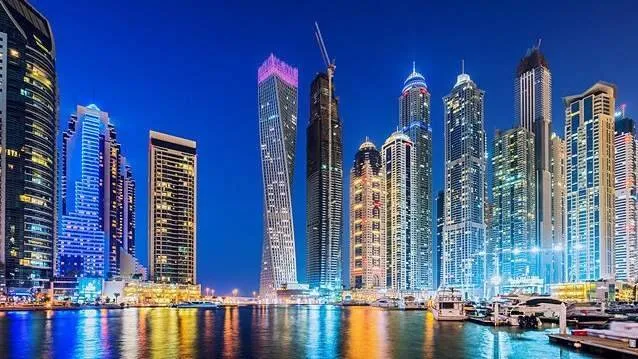

In [9]:
img = read_3d('input.jpeg')[:,:,0]
out = pooling(img, average_pooling, stride=2)
print("Input shape :")
print(img.shape)
display(Image2(filename='input.jpeg'))

Output shape : 
(179, 319)


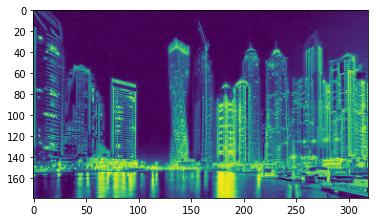

In [10]:
print("Output shape : ")
print(out.shape)
show(out)

#### Convolution layer function: 
It accepts as input a volume (image or activation maps), number of
filters, kernel dimensions, stride, padding and the non-linear function. The function must convolve
the input volume (after padding if specified) with each of the kernels (at the specified stride size)
and generates an output activation volume after applying the specified non-linearity. Display the
input image or activation maps, the filter kernels and the output activation maps. Verify that the
output of this function does indeed have the expected size (W × H × C) as discussed in class

In [11]:
'''
convolution layer functions
img : image input with multiple channels (dimension = h, w, num_ch)
kernels : list of kernels (dimension = num_kernel, num_ch, h_k, h_w)
stride : default value = 1
padding : default value = 0
activation : identity function 

output : (dimension = num_kernel, output_height, output_width) height and weight are calculated using standard formula
'''
def convolution_layer(img, kernels, stride=1, padding=0, activation=lambda x: x):
    h_i, w_i, nc_i = img.shape
    num_krl, nc_k, h_k, w_k = kernels.shape
    o_h = int(((h_i - h_k + 2*padding)/stride) + 1)
    o_w = int(((w_i - w_k + 2*padding)/stride) + 1)
    
    output = np.zeros((o_h, o_w, num_krl))
    
    for i in range(num_krl):
        tmp_kernel = kernels[i,:,:,:]
        tmp = convolution_d(img, tmp_kernel, stride=stride, padding=padding, activation=activation)
        output[:,:,i] = tmp
    return output

In [12]:
img = read_3d('input1.jpeg')
kernels = np.array([    
    [[[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
     [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]],
     [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]],
    [[[-1, -1, -1], [0, 0, 0], [1, 1, 1]],
     [[-1, -1, -1], [0, 0, 0], [1, 1, 1]],
     [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]],
    [[[3, 10, 3], [0, 0, 0], [-3, -10, -3]],
     [[3, 10, 3], [0, 0, 0], [-3, -10, -3]],
     [[3, 10, 3], [0, 0, 0], [-3, -10, -3]]]
])
out_3 = convolution_layer(img, kernels, stride=2, padding=1, activation=relu)

- displaying input image

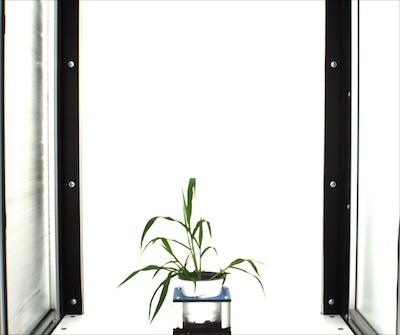

In [13]:
display(Image2(filename='input1.jpeg'))

- displaying all kernels and corresponding activation map

Output shape : (168, 200, 3)

Kernel 1

[[[-1  0  1]
  [-1  0  1]
  [-1  0  1]]

 [[-1  0  1]
  [-1  0  1]
  [-1  0  1]]

 [[-1  0  1]
  [-1  0  1]
  [-1  0  1]]]
Corresponding activation map


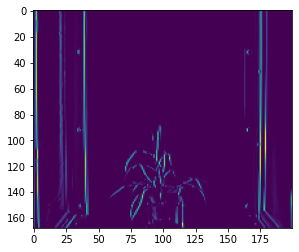


Kernel 2

[[[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]

 [[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]

 [[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]]
Corresponding activation map


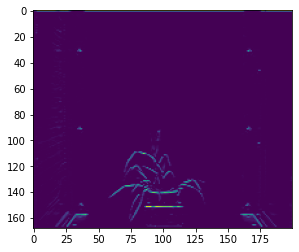


Kernel 3

[[[  3  10   3]
  [  0   0   0]
  [ -3 -10  -3]]

 [[  3  10   3]
  [  0   0   0]
  [ -3 -10  -3]]

 [[  3  10   3]
  [  0   0   0]
  [ -3 -10  -3]]]
Corresponding activation map


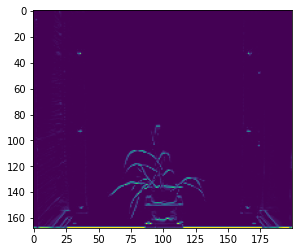

In [14]:
print(f"Output shape : {out_3.shape}")
for i in range(len(kernels)):
    print(f"\nKernel {i+1}\n")
    print(kernels[i])
    print("Corresponding activation map")
    show(out_3[:,:,i])

In [15]:
'''
convolution layer functions
img : image input with multiple channels (dimension = N_image, h, w, num_ch)
kernels : list of kernels (dimension = num_kernel, num_ch, h_k, h_w)
stride : default value = 1
padding : default value = 0
activation : identity function 

output : (dimension = num_kernel, output_height, output_width) height and weight are calculated using standard formula
'''
def convolution_layer_multiple_images(img, kernels, stride=1, padding=0, activation=lambda x: x):
    n_img, h_i, w_i, nc_i = img.shape
    num_krl, nc_k, h_k, w_k = kernels.shape
    o_h = int(((h_i - h_k + 2*padding)/stride) + 1)
    o_w = int(((w_i - w_k + 2*padding)/stride) + 1)
    
    output = np.zeros((n_img, o_h, o_w, num_krl))
    
    for i in range(n_img):
        img_i = img[i,:,:,:]
        tmp = convolution_layer(img_i, kernels, stride=stride, padding=padding, activation=activation)
        output[i,:,:,:] = tmp
    return output

#### Pooling layer function: 
It accepts as input the activation map volume, the pooling function,
stride, and generates a pooled output volume. Display the input and output volumes. A special
case for performing Global Average Pooling should also be provided.

In [ ]:
def pooling(map_input, pooling_func, stride=1):
    h, w = map_input.shape

    # Calculate output dimensions
    oh = int(h/stride)
    ow = int(w/stride)
    output = np.zeros((oh, ow))
    
    # pooling operation
    for i in range(0, h - stride + 1, stride):
        for j in range(0, w - stride + 1, stride):
            # print(i,j,d)
            tmp = map_input[i:i+stride, j:j+stride]
            # print(tmp.shape)
            # print(f"tmp shape : {tmp.shape}")
            tmp_out = pooling_func(tmp)
            # print(tmp)
            # print(tmp_out)
            output[int(i/stride), int(j/stride)] = tmp_out

    return output

In [16]:
'''
image dimension : (height, width, num_channel)
output dimension : (out_ht, out_width, num_channel)
'''
def pooling_layer(map_input, pooling_func, stride=1):
    # Getting input shape
    # print(map_input.shape)
    h, w, ch = map_input.shape

    # Calculate output dimensions
    oh = int(h/stride)
    ow = int(w/stride)
    output = np.zeros((oh, ow, ch))
    
    # pooling operation
    for d in range(ch):
        for i in range(0, h - stride + 1, stride):
            for j in range(0, w - stride + 1, stride):
                # print(i,j,d)
                tmp = map_input[i:i+stride, j:j+stride, d]
                # print(tmp.shape)
                # print(f"tmp shape : {tmp.shape}")
                tmp_out = pooling_func(tmp)
                # print(tmp)
                # print(tmp_out)
                output[int(i/stride), int(j/stride), d] = tmp_out

    return output

Input shape :
(359, 638, 3)


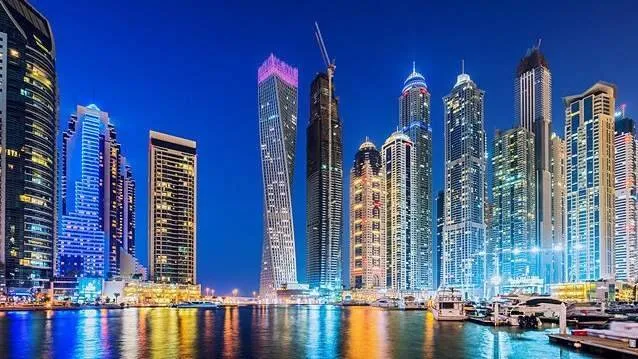

Output shape : 
(179, 319, 3)
(179, 319)


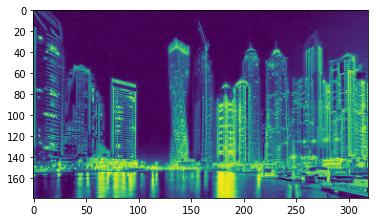

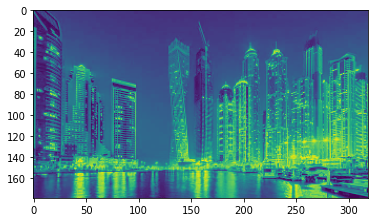

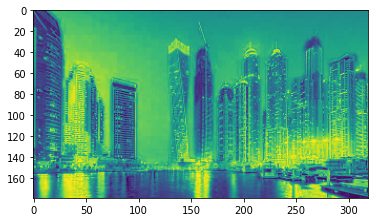

In [17]:
img = read_3d('input.jpeg')
out = pooling_layer(img, average_pooling, stride=2)
print("Input shape :")
print(img.shape)
display(Image2(filename='input.jpeg'))
print("Output shape : ")
print(out.shape)

print(out[:,:,0].shape)
show(out[:,:,0])
show(out[:,:,1])
show(out[:,:,2])

In [18]:
'''
input : h x w x ch
'''
def GAP(img):
    h, w, ch = img.shape
    
    out = np.zeros(ch)
    
    for i in range(ch):
        out[i] = average_pooling(img[:,:,i])
    
    return out

#### flattening
It accepts as input the activation map volume output by the
pooling layer and generates a vector of a specified size. It is important to note that this function
has a weight matrix associated with it whose size is chosen such that the input and desired output
sizes are matched

In [19]:
def flatten(img):
    h, w, ch = img.shape
    out = np.zeros(ch*h*w)
    #print(out.shape)
    
    for i in range(h):
        for j in range(w):
            for k in range(ch):
                idx = k + ch*j + w*ch*i
                out[idx] = img[i][j][k]
                    
    return out

In [20]:
img = read_3d('input.jpeg')[0:50,0:50]
out_img = convolution_layer(img, kernels, stride=2, padding=1, activation=relu)
print(f"Input map shape : {out_img.shape}")
ret = flatten(out_img)
print(f"Flattened vector shape : {ret.shape}")

Input map shape : (25, 25, 3)
Flattened vector shape : (1875,)


#### Multilayer Perceptron (MLP) function: 
It accepts as input a vector, the number of hidden layers, the size of each hidden layer, the non-linear function, and the size of the output layer. This function should generate an output vector of the specified size. Generate the output with and without the softmax function applied to the output layer.

In [21]:
'''
input : vector
output : vector
weights and bias are initialized randomly based on number and size of hidden layers
'''
def MLP(vec, num_hidden_layers, hidden_layer_size, activation_func, output_size, apply_softmax=False):
    wts = []
    bias = []
    input_size = vec.shape[0]
    
    # Initialize weights and bias for hidden layers
    for i in range(num_hidden_layers):
        if i == 0:
            wts.append(np.random.randn(hidden_layer_size, input_size))
        else:
            wts.append(np.random.randn(hidden_layer_size, hidden_layer_size))
        bias.append(np.zeros((hidden_layer_size, 1)))
    
    # Initialize wts and bias for output layer
    wts.append(np.random.randn(output_size, hidden_layer_size))
    bias.append(np.zeros((output_size, 1)))
    
    # Forward pass through the network
    x = vec.reshape((input_size, 1))
    
    # Compute output for each hidden layer
    for i in range(num_hidden_layers):
        z = np.dot(wts[i], x) + bias[i]
        x = activation_func(z)
        
    # Compute output for output layer
    z = np.dot(wts[num_hidden_layers], x) + bias[num_hidden_layers]
    
    # Apply softmax function to output layer if specified
    if apply_softmax:
        output = softmax(z)
    else:
        output = z
    
    return output

#### Feed-forward path: 
Finally, use the functions you have written to implement a CNN with the following architecture. The CNN must accept an image input and output a vector of appropriate dimension. In other words, the function must effectively implement the feed-forward path in a CNN.
- Input image of size 32 × 32 × 3. Use images from the CIFAR-10 dataset.
- Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
- Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
- A Global Average Pooling (GAP) layer.
- An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s output and maps it to 10 output nodes. Use sigmoid activation for the MLP (softmax in the o/p layer).

Verify that your composition of function accepts and image input and outputs a vector.

In [22]:
def ff_path(img, kernels_16, kernels_8):
    conv1 = convolution_layer(img, kernels_16, stride=2, activation=sigmoid)
    pool1 = pooling_layer(conv1, max_pooling, stride=2)
    conv2 = convolution_layer(pool1, kernels_8, stride=2, activation=sigmoid)
    pool2 = pooling_layer(conv2, max_pooling, stride=2)
    vec = GAP(pool2)
    out = MLP(vec, 1, len(vec), sigmoid, 10, apply_softmax=True)
    return out

In [23]:
img = read_3d('input.jpeg')[0:32,0:32,:]
kernels_16 = gen_kernel(16, 3, 3)
kernels_8  = gen_kernel(8, 16, 3)

In [24]:
print(f"Image shape : {img.shape}")
print(f"kernels16 shape : {kernels_16.shape}")
print(f"kernels8 shape : {kernels_8.shape}")

Image shape : (32, 32, 3)
kernels16 shape : (16, 3, 3, 3)
kernels8 shape : (8, 16, 3, 3)


In [25]:
output = ff_path(img, kernels_16, kernels_8)

/tmp/ipykernel_709/843332748.py:36: RuntimeWarning: overflow encountered in exp
  x = 1.0 / (1.0 + np.nan_to_num(np.exp(-1.0*x)))


In [26]:
print(output)

[[0.2091467 ]
 [0.02974104]
 [0.25230125]
 [0.0058378 ]
 [0.14955213]
 [0.00237437]
 [0.01024042]
 [0.01518704]
 [0.18835994]
 [0.1372593 ]]
